In [328]:
import pandas as pd
import numpy as np
import re
import string
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.nn.utils.rnn import pad_sequence

# Download NLTK resources (only once)
nltk.download("stopwords")
nltk.download("wordnet")


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/prathyusha/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/prathyusha/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [329]:
df = pd.read_csv("Tweets.csv")
df.head()


,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [330]:
D = df[['text', 'airline_sentiment']]
D.head()

,text,airline_sentiment
0,@VirginAmerica What @dhepburn said.,neutral
1,@VirginAmerica plus you've added commercials t...,positive
2,@VirginAmerica I didn't today... Must mean I n...,neutral
3,@VirginAmerica it's really aggressive to blast...,negative
4,@VirginAmerica and it's a really big bad thing...,negative


In [331]:
print("Shape of the dataset:", df.shape)

Shape of the dataset: (14640, 15)


In [332]:
df.columns

Index(['tweet_id', 'airline_sentiment', 'airline_sentiment_confidence',
       'negativereason', 'negativereason_confidence', 'airline',
       'airline_sentiment_gold', 'name', 'negativereason_gold',
       'retweet_count', 'text', 'tweet_coord', 'tweet_created',
       'tweet_location', 'user_timezone'],
      dtype='object')

In [333]:
D = df['text']
D.head()

0                  @VirginAmerica What @dhepburn said.
1    @VirginAmerica plus you've added commercials t...
2    @VirginAmerica I didn't today... Must mean I n...
3    @VirginAmerica it's really aggressive to blast...
4    @VirginAmerica and it's a really big bad thing...
Name: text, dtype: object

In [334]:
L = df["airline_sentiment"]

In [335]:
D.isna()

0        False
1        False
2        False
3        False
4        False
         ...  
14635    False
14636    False
14637    False
14638    False
14639    False
Name: text, Length: 14640, dtype: bool

In [336]:
L.isna()

0        False
1        False
2        False
3        False
4        False
         ...  
14635    False
14636    False
14637    False
14638    False
14639    False
Name: airline_sentiment, Length: 14640, dtype: bool

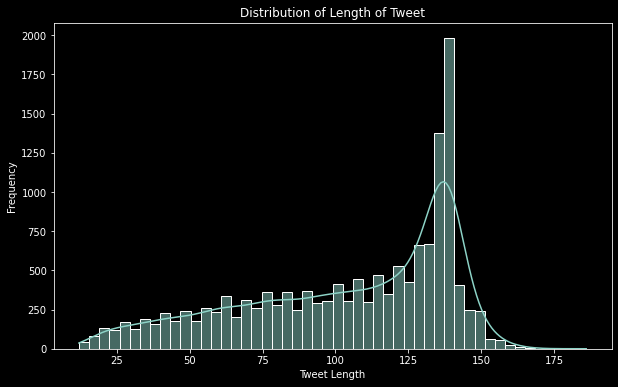

In [337]:
# df['tweet_length'] = df['text'].apply(len)
plt.figure(figsize=(10,6))
sns.histplot(df['text'].apply(len), bins=50, kde=True)
plt.title('Distribution of Length of Tweet')
plt.xlabel('Tweet Length')
plt.ylabel('Frequency')
plt.show()


In [338]:
df['airline_sentiment'].value_counts()

airline_sentiment
negative    9178
neutral     3099
positive    2363
Name: count, dtype: int64

In [339]:
df['airline_sentiment'].value_counts().index

Index(['negative', 'neutral', 'positive'], dtype='object', name='airline_sentiment')

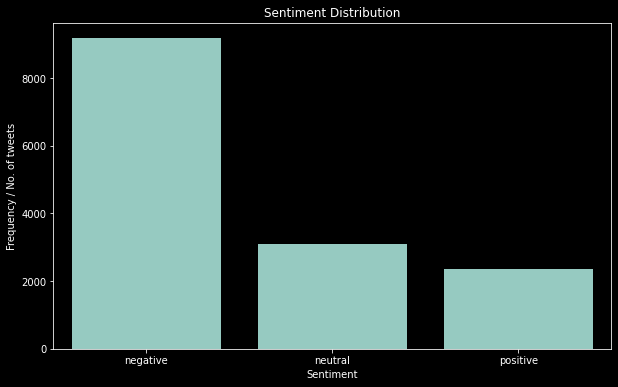

In [340]:
plt.figure(figsize=(10,6))
# sns.histplot(df['text'].apply(len), bins=50, kde=True)
sns.barplot(
    x=df['airline_sentiment'].value_counts().index,
    y=df['airline_sentiment'].value_counts()
)
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Frequency / No. of tweets')
plt.show()

In [341]:
df['airline_sentiment'].value_counts()

airline_sentiment
negative    9178
neutral     3099
positive    2363
Name: count, dtype: int64

In [ ]:
# # import matplotlib.font_manager as fm

def wordCloudPic(sent):
    text = " ".join(df[df['airline_sentiment'] == sent]['text'])
    wordcloud = WordCloud(width=500, height=200, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    # plt.imshow(wordcloud, interpolation='bilinear')
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.title(f"WordCloud of {sent.upper()} Tweets")
    plt.show()


In [ ]:
for sent in df['airline_sentiment'].unique():
    wordCloudPic(sent)

In [344]:
def dfTextCount(textDataFrame):
  tokens = " ".join(textDataFrame).split()
  counts = Counter(tokens).most_common(30)
  words, counts = zip(*counts)
  plt.figure(figsize=(12, 6))
  plt.barh(words[::-1], counts[::-1], color='red')
  plt.xlabel("Frequency")
  plt.title("30 Most Frequent Words")
  plt.show()


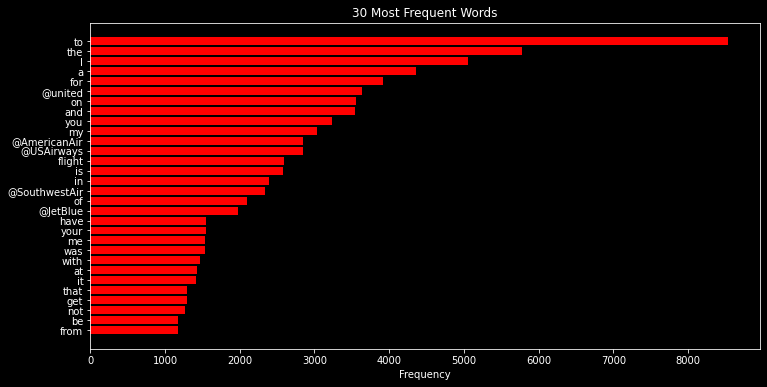

In [345]:
dfTextCount(df['text'])

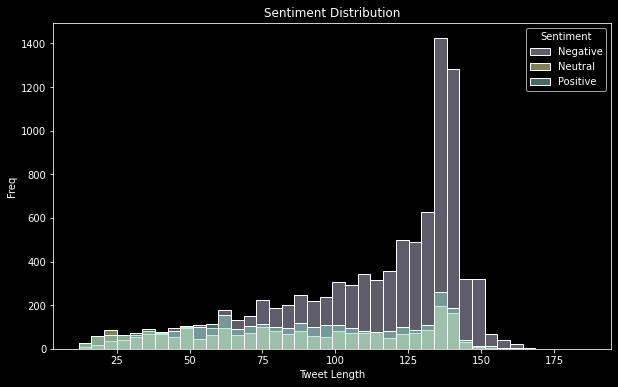

In [346]:
df['tweetLen'] = df['text'].apply(len)

plt.figure(figsize=(10, 6))
# sns.histplot(
#     data=df,
#     x='tweet_length',
#     hue='airline_sentiment',
#     bins=40,
#     kde=True,
#     palette='Set2'
#     )

sns.histplot(
    data=df,
    x='tweetLen',
    hue='airline_sentiment',
    bins=40
    )
plt.title('Sentiment Distribution')
plt.xlabel('Tweet Length')
plt.ylabel('Freq')
plt.legend(
    title='Sentiment',
    labels=['Negative', 'Neutral', 'Positive']
    )
plt.show()


In [347]:
stopWords = set(stopwords.words('english'))


In [348]:
lemmat = WordNetLemmatizer()

In [349]:
def textPreprocess(text):
    text = text.lower()
    text = re.sub(f"[{string.punctuation}]", "", text)
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"@[^\s]+", "", text)
    text = re.sub(r"\s+", " ", text)
    words = re.findall(r'\b\w+\b', text)
    words = [word for word in words if len(word) > 2]
    words = [word for word in words if word.isalpha()]

    cleanWords = [lemmat.lemmatize(word) for word in words if word not in stopWords]
    return " ".join(cleanWords)

In [350]:
# Apply preprocessing
df['cleanText'] = df['text'].astype(str).apply(textPreprocess)

In [351]:
D = df['cleanText']

In [352]:
# dfTextCount(df['cleanText'])

In [353]:
def trainTestSplit(D, L):
  Dtr, Dtst, Ltr, Ltst = train_test_split(D, L, test_size=0.2, stratify=L, random_state=42)
  return Dtr, Dtst, Ltr, Ltst

In [354]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

In [355]:
tfidf = TfidfVectorizer(stop_words='english')
BOWvectorizer = CountVectorizer(stop_words='english')

In [356]:
label_map = {'negative': 0, 'neutral': 1, 'positive': 2}
df['label'] = df['airline_sentiment'].map(label_map)

In [357]:
Dtr, Dtst, Ltr, Ltst = trainTestSplit(D, L)
DtrTFIDF = tfidf.fit_transform(Dtr)
DtrBOW = BOWvectorizer.fit_transform(Dtr)
DtstTFIDF = tfidf.transform(Dtst)
DtstBOW = BOWvectorizer.transform(Dtst)
original_text_test = train_test_split(df['cleanText'], test_size=0.2, stratify=df['label'], random_state=42)[0].reset_index(drop=True)



In [358]:
DtstBOW.shape[1]

10140

In [359]:
DtstTFIDF.shape[1]

10140

In [360]:
def LR(Dtr, Dtst, Ltr, Ltst):
  logRe = LogisticRegression(max_iter=2000, random_state=42,solver='liblinear')
  logRe.fit(Dtr, Ltr)
  pred = logRe.predict(Dtst)
  print(classification_report(Ltst, pred))
  cm = confusion_matrix(Ltst, pred)
  sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
  plt.xlabel("Predicted")
  plt.ylabel("True")
  plt.title("Logistic regression Confusion matrix")
  plt.show()
  return pred

              precision    recall  f1-score   support

    negative       0.79      0.95      0.86      1835
     neutral       0.67      0.44      0.53       620
    positive       0.82      0.54      0.65       473

    accuracy                           0.78      2928
   macro avg       0.76      0.64      0.68      2928
weighted avg       0.77      0.78      0.76      2928



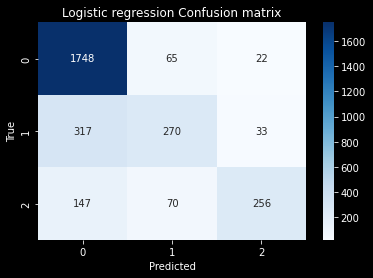

In [361]:
pred = LR(DtrTFIDF, DtstTFIDF, Ltr, Ltst)

In [362]:
inv_label_map = {v: k for k, v in label_map.items()}
errors = np.where(pred != Ltst)[0]

print(f"\nTotal Misclassified Tweets: {len(errors)}")

for i in range(min(15, len(errors))):
    idx = errors[i]
    print(f"{i+1}")
    print("Cleaned Text:", original_text_test.iloc[idx])
    print("True Label:", Ltst.iloc[idx])  # <-- no need inv_label_map
    print("Predicted Label:", pred[idx])  # <-- no need inv_label_map
    # print("-" * 100)




Total Misclassified Tweets: 654
1
Cleaned Text: united would cost
True Label: neutral
Predicted Label: negative
2
Cleaned Text: usairways used get email prepurchase snack time check got neither tomorrow trip get sent
True Label: positive
Predicted Label: negative
3
Cleaned Text: dont see united
True Label: neutral
Predicted Label: negative
4
Cleaned Text: americanair tell flight dfw phl cancelled flightled tomorrow
True Label: negative
Predicted Label: neutral
5
Cleaned Text: southwestair rapid award member point apply taken round trip
True Label: positive
Predicted Label: negative
6
Cleaned Text: nice virginamerica man steel might faster wifi saying sciencebehindtheexperience
True Label: negative
Predicted Label: neutral
7
Cleaned Text: americanair minute flight okc make wait minute cause gate isnt empty epicfail poorplanning
True Label: neutral
Predicted Label: negative
8
Cleaned Text: virginamerica making bosgtlas non stop permanently anytime soon
True Label: neutral
Predicted Labe

              precision    recall  f1-score   support

    negative       0.84      0.90      0.87      1835
     neutral       0.62      0.57      0.59       620
    positive       0.75      0.63      0.68       473

    accuracy                           0.78      2928
   macro avg       0.73      0.70      0.71      2928
weighted avg       0.78      0.78      0.78      2928



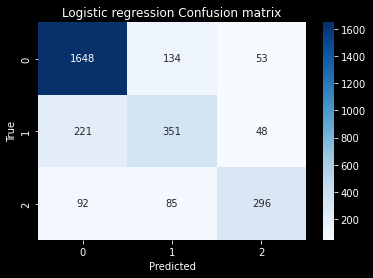

array(['negative', 'negative', 'negative', ..., 'negative', 'negative',
       'negative'], shape=(2928,), dtype=object)

In [363]:
LR(DtrBOW, DtstBOW, Ltr, Ltst)

In [364]:
def naiveB(Dtr, Dtst, Ltr, Ltst):
  naiveBayes = MultinomialNB()
  naiveBayes.fit(Dtr, Ltr)
  pred = naiveBayes.predict(Dtst)
  print(classification_report(Ltst, pred))
  # print(confusion_matrix(Ltst, pred))
  cm = confusion_matrix(Ltst, pred)
  sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
  plt.xlabel("Predicted")
  plt.ylabel("True")
  plt.title("NB Confusion matrix")
  plt.show()

              precision    recall  f1-score   support

    negative       0.67      1.00      0.80      1835
     neutral       0.75      0.14      0.24       620
    positive       0.85      0.19      0.31       473

    accuracy                           0.68      2928
   macro avg       0.76      0.44      0.45      2928
weighted avg       0.72      0.68      0.60      2928



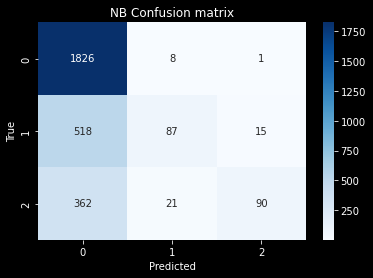

In [365]:
naiveB(DtrTFIDF, DtstTFIDF, Ltr, Ltst)

              precision    recall  f1-score   support

    negative       0.77      0.95      0.85      1835
     neutral       0.70      0.38      0.49       620
    positive       0.76      0.52      0.62       473

    accuracy                           0.76      2928
   macro avg       0.74      0.62      0.65      2928
weighted avg       0.75      0.76      0.74      2928



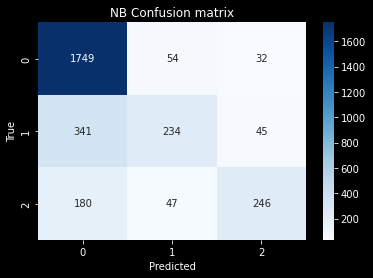

In [366]:
naiveB(DtrBOW, DtstBOW, Ltr, Ltst)

In [367]:
# !pip install transformers datasets



In [368]:
# %pip install tensorflow


TFIDF DNN


In [369]:
class TFIDFDNN(nn.Module):
    def __init__(self, inputDim, hiddenDim, classesNum):
        super(TFIDFDNN, self).__init__()
        self.fc1 = nn.Linear(inputDim, hiddenDim)
        self.dropout1 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(hiddenDim, 64)
        self.dropout2 = nn.Dropout(0.2)
        self.out = nn.Linear(64, classesNum)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout1(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout2(x)
        return self.out(x)

In [370]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns

In [371]:
# df = pd.read_csv("Tweets.csv")

In [372]:
labEn = LabelEncoder()
df["labelsEncoded"] = labEn.fit_transform(df["airline_sentiment"])

In [373]:
# tfidf = TfidfVectorizer(max_features=5000)
tfidf = TfidfVectorizer(stop_words='english')
D = tfidf.fit_transform(df["text"]).toarray()
L = df["labelsEncoded"].values

In [374]:
indices = np.arange(len(df))
train_idx, test_indices = train_test_split(indices, test_size=0.2, random_state=42)
Dtr, Dtst = D[train_idx], D[test_indices]
Ltr, Ltst = L[train_idx], L[test_indices]


In [375]:
# Dtr, Dtst, Ltr, Ltst = train_test_split(D, L, test_size=0.2, random_state=42)

In [376]:
DtrTensor = torch.tensor(Dtr, dtype=torch.float32)
LtrTensor = torch.tensor(Ltr, dtype=torch.long)
DtstTensor = torch.tensor(Dtst, dtype=torch.float32)
LtstTensor = torch.tensor(Ltst, dtype=torch.long)

trDataset = TensorDataset(DtrTensor, LtrTensor)
tstDataset = TensorDataset(DtstTensor, LtstTensor)
trLoader = DataLoader(trDataset, batch_size=32, shuffle=True)
tstLoader = DataLoader(tstDataset, batch_size=32)

In [377]:
def modelTraining(D, trLoader, tstLoader, model, name, dividend=10, epochs=100):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # model = TFIDFDNN(inputDim=D.shape[1], hiddenDim=256, classesNum=3).to(device)
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    # Training loop
    for epoch in range(epochs):
        model.train()
        totalLoss = 0
        for Dbatch, Lbatch in trLoader:
            Dbatch, Lbatch = Dbatch.to(device), Lbatch.to(device)
            # Dbatch = Dbatch.float()
            optimizer.zero_grad()
            output = model(Dbatch)
            loss = criterion(output, Lbatch)
            loss.backward()
            optimizer.step()
            totalLoss += loss.item()
        if (epoch+1) % dividend == 0:
          print(f"Epoch {epoch+1}, Loss: {totalLoss:.4f}")

    # ====== 4. Evaluation ======
    model.eval()
    predsList, labelsList = [], []

    with torch.no_grad():
        for Dbatch, Lbatch in tstLoader:
            Dbatch = Dbatch.to(device)
            # Dbatch = Dbatch.float()
            output = model(Dbatch)
            preds = torch.argmax(output, dim=1).cpu().numpy()
            predsList.extend(preds)
            labelsList.extend(Lbatch.numpy())

    print("\nClassification Report:\n")
    print(classification_report(labelsList, predsList, target_names=labEn.classes_))

    # Use the same label encoder for class names
    cm = confusion_matrix(labelsList, predsList)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=labEn.classes_,
                yticklabels=labEn.classes_)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(name)
    plt.show()

LSTM (PyTorch)

Epoch 100, Loss: 3.4467
Epoch 200, Loss: 3.3521
Epoch 300, Loss: 3.1578
Epoch 400, Loss: 3.3858
Epoch 500, Loss: 3.3382
Epoch 600, Loss: 3.3047
Epoch 700, Loss: 3.3986
Epoch 800, Loss: 3.2984
Epoch 900, Loss: 3.3450
Epoch 1000, Loss: 3.5475

Classification Report:

              precision    recall  f1-score   support

    negative       0.86      0.85      0.86      1889
     neutral       0.58      0.46      0.51       580
    positive       0.56      0.75      0.64       459

    accuracy                           0.76      2928
   macro avg       0.67      0.68      0.67      2928
weighted avg       0.76      0.76      0.76      2928



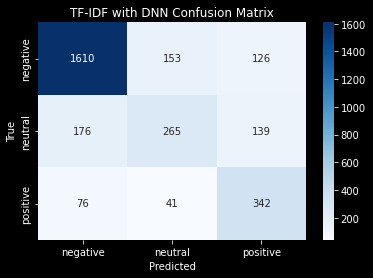

In [378]:
model = TFIDFDNN(inputDim=D.shape[1], hiddenDim=256, classesNum=3)
modelTraining(D, trLoader, tstLoader, model, "TF-IDF with DNN Confusion Matrix",dividend = 100, epochs = 1000)

In [379]:
class LSTMClassifier(nn.Module):
    def __init__(self, vocabSize, embeddDim, hiddenDim, classesNum):
        super(LSTMClassifier, self).__init__()
        self.embedding = nn.Embedding(vocabSize, embeddDim, padding_idx=0)
        self.lstm = nn.LSTM(embeddDim, hiddenDim, batch_first=True)
        self.fc = nn.Linear(hiddenDim, classesNum)
    def forward(self, d):
        d = self.embedding(d)
        _, (hiddenNetwork, _) = self.lstm(d)
        return self.fc(hiddenNetwork[-1])

In [380]:
class TweetDataset(Dataset):
    def __init__(self, D, L):
        self.D = [torch.tensor(d, dtype=torch.long) for d in D]
        self.L = torch.tensor(L.values, dtype=torch.long)
    def __len__(self):
        return len(self.L)
    def __getitem__(self, id):
        return self.D[id], self.L[id]

In [381]:
def collate(batch):
    texts, labels = zip(*batch)
    padded = pad_sequence(texts, batch_first=True, padding_value=0)
    return padded, torch.tensor(labels)

In [382]:
# stopWords = set(stopwords.words("english"))
# lemmat = WordNetLemmatizer()

In [383]:
def textPreprocess(text):
    text = text.lower()
    text = re.sub(f"[{string.punctuation}]", "", text)
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"@[^\s]+", "", text)
    text = re.sub(r"\s+", " ", text)
    words = re.findall(r'\b\w+\b', text)
    words = [word for word in words if len(word) > 2 and word.isalpha()]
    cleanWords = [lemmat.lemmatize(word) for word in words if word not in stopWords]
    return cleanWords

In [384]:
# df["tokens"] = df["text"].apply(textPreprocess)
df['tokens'] = df['cleanText']

In [385]:
fullTokens = [token for tokens in df["tokens"] for token in tokens]
vocab = {word: i+2 for i, (word, _) in enumerate(Counter(fullTokens).most_common(10000))}
vocab["<PAD>"] = 0
vocab["<UNK>"] = 1

def encode(tokens):
    return [vocab.get(w, 1) for w in tokens]

df["encoded"] = df["tokens"].apply(encode)

In [386]:
Dtr, Dtst, Ltr, Ltst = train_test_split(df["encoded"], df["labelsEncoded"], test_size=0.2, random_state=42)

In [387]:
trDataset = TweetDataset(Dtr, Ltr)
tstDataset = TweetDataset(Dtst, Ltst)
trLoader = DataLoader(trDataset, batch_size=32, shuffle=True, collate_fn=collate)
tstLoader = DataLoader(tstDataset, batch_size=32, collate_fn=collate)

In [388]:
model = LSTMClassifier(len(vocab), 32, 32, 3)

Epoch 100, Loss: 147.9174
Epoch 200, Loss: 103.8915
Epoch 300, Loss: 92.9827
Epoch 400, Loss: 74.3935
Epoch 500, Loss: 146.4271
Epoch 600, Loss: 65.2512
Epoch 700, Loss: 59.9333
Epoch 800, Loss: 74.0700
Epoch 900, Loss: 75.5139
Epoch 1000, Loss: 78.8371

Classification Report:

              precision    recall  f1-score   support

    negative       0.84      0.83      0.83      1889
     neutral       0.41      0.49      0.45       580
    positive       0.60      0.47      0.53       459

    accuracy                           0.70      2928
   macro avg       0.62      0.60      0.60      2928
weighted avg       0.71      0.70      0.71      2928



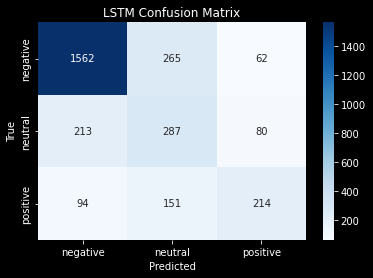

In [389]:
modelTraining(D, trLoader, tstLoader, model, "LSTM Confusion Matrix", dividend = 100, epochs = 1000)